In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

/Users/sergiobd373/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Data Loading and Cleaning

In this section, we perform the following tasks:
1. **Load GDP Data**: We read the GDP growth data for Denmark from a CSV file and filter it for the relevant country. The data is then reshaped into a long format with columns for 'Year' and 'GDP Growth', and non-numeric year values are removed. Unnecessary columns are dropped, and missing values are handled.
2. **Load Inflation Data**: We perform a similar process for inflation data, reading it from a CSV file, filtering for Denmark, and reshaping the data into a long format with columns for 'Year' and 'Inflation'. Non-numeric year values are also removed, and unnecessary columns are discarded.
3. **Merge the Data**: After cleaning, we merge the GDP and inflation datasets on 'Year' to create a combined dataset that allows us to analyze both variables in parallel over time.



In [2]:
gdp_df = pd.read_csv('GDPR_denmark/API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_127.csv', skiprows=4)

# Filter for Denmark Only
gdp_df = gdp_df[gdp_df['Country Name'] == 'Denmark']

gdp_df = gdp_df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])

gdp_df = gdp_df.melt(id_vars=['Country Name'], var_name='Year', value_name='GDP_Growth')

# Remove Non-Numeric Year Values
gdp_df = gdp_df[gdp_df['Year'].str.isnumeric()]
gdp_df['Year'] = gdp_df['Year'].astype(int)
gdp_df = gdp_df.dropna()

In [3]:
inflation_df = pd.read_csv('Inflation_denmark/API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_59.csv', skiprows=4)

# Filter for Denmark
inflation_df = inflation_df[inflation_df['Country Name'] == 'Denmark']

inflation_df = inflation_df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])

# Convert from wide to long format
inflation_df = inflation_df.melt(id_vars=['Country Name'], var_name='Year', value_name='Inflation')

# Ensure Year is numeric and drop NaNs
inflation_df = inflation_df[inflation_df['Year'].str.isnumeric()]
inflation_df['Year'] = inflation_df['Year'].astype(int)
inflation_df = inflation_df.dropna()

In [25]:
df = pd.merge(gdp_df, inflation_df, on=['Country Name', 'Year'])
df = df.drop(columns=['Country Name'])
df

,Year,GDP_Growth,Inflation
0,1961,6.378832,3.451629
1,1962,5.666822,7.377820
2,1963,0.637021,6.105033
3,1964,9.269938,3.092784
4,1965,4.555255,5.450000
...,...,...,...
58,2019,1.711401,0.758132
59,2020,-1.780106,0.420712
60,2021,7.382066,1.853045
61,2022,1.540173,7.696567


# Calculate Year-over-Year Differences

1. **Focus on Trends and Changes**: Instead of directly comparing raw GDP growth and inflation values, we calculate the year-over-year (YoY) differences to focus on the changes between consecutive years. This helps to better understand the dynamics between GDP growth and inflation, as the change (or acceleration) in these values is often more important than their absolute levels. By working with changes, we can capture economic trends and turning points more effectively.

2. **Mitigate Noise in Data**: Raw GDP and inflation data may have seasonal variations or one-off events that could obscure underlying patterns. By focusing on the differences between years, we smooth out any cyclical fluctuations, making it easier to spot long-term relationships and correlations.

3. **Improved Statistical Analysis**: Year-over-year differences typically make the data more stationary, which is important for certain statistical models like Granger Causality or Vector Autoregression (VAR), as these models assume stationarity in the data. Analyzing changes instead of raw values helps in meeting this assumption, leading to more reliable and interpretable results.

After calculating the differences, we drop unnecessary columns and remove missing values to clean the dataset for further analysis.


In [6]:
df['ΔGDP_Growth'] = df['GDP_Growth'].diff()  # Change in GDP Growth
df['ΔInflation'] = df['Inflation'].diff()  
df = df.dropna()

# Visualize and Analyze Year-over-Year Changes
In this section, we perform both visual and statistical analysis to assess the relationship between the year-over-year changes in GDP growth and inflation:

1. **Visualize Year-over-Year Changes**: We plot the year-over-year changes in GDP growth and inflation on a line graph. This visualization helps to observe how both variables fluctuate over time, making it easier to identify trends, peaks, and troughs.

2. **Calculate and Interpret Correlation**: We calculate the Pearson correlation coefficient between the changes in GDP growth and inflation. This correlation helps quantify the strength and direction of the relationship between the two variables. A strong positive or negative correlation could suggest that changes in one variable might be influencing the other.

3. **Regression Analysis**: We then create a scatter plot with a regression line to further explore the relationship between the changes in GDP growth and inflation. The regression line helps to visualize the linear relationship between these two variables, making it easier to understand how one might predict the other.


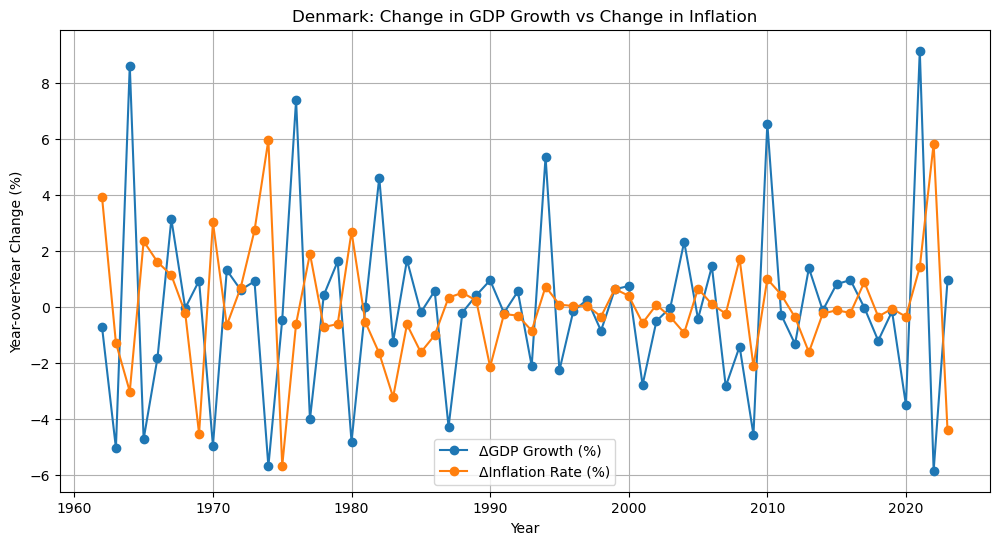

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['ΔGDP_Growth'], label='ΔGDP Growth (%)', marker='o', linestyle='-')
plt.plot(df['Year'], df['ΔInflation'], label='ΔInflation Rate (%)', marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Year-over-Year Change (%)')
plt.title('Denmark: Change in GDP Growth vs Change in Inflation')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
correlation = df['ΔGDP_Growth'].corr(df['ΔInflation'])
print(f'Correlation between ΔGDP Growth and ΔInflation: {correlation:.2f}')

Correlation between ΔGDP Growth and ΔInflation: -0.31


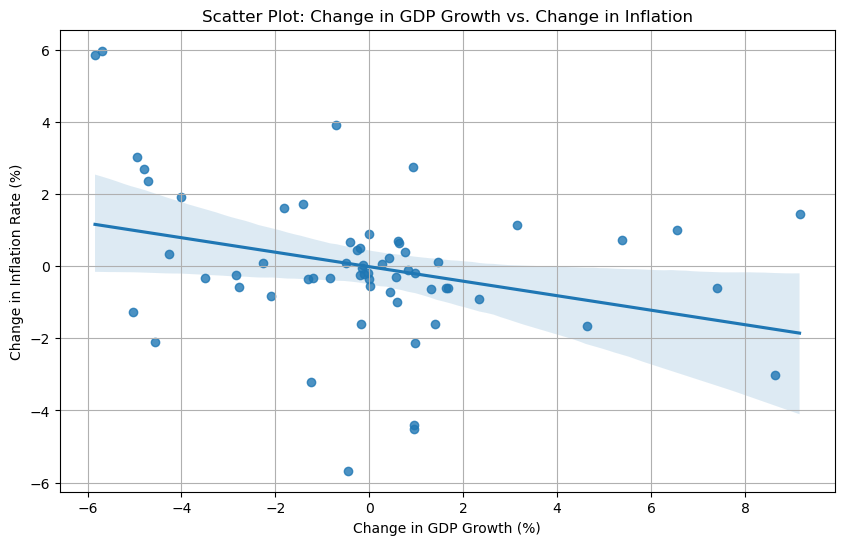

In [10]:
plt.figure(figsize=(10, 6))
sns.regplot(x='ΔGDP_Growth', y='ΔInflation', data=df)
plt.xlabel('Change in GDP Growth (%)')
plt.ylabel('Change in Inflation Rate (%)')
plt.title('Scatter Plot: Change in GDP Growth vs. Change in Inflation')
plt.grid(True)
plt.show()

# Granger Causality Test
This section conducts a Granger Causality test to determine if past values of GDP growth can predict changes in inflation or if inflation changes influence GDP growth. The test is performed using `statsmodels` with a maximum lag of 3 years.


In [11]:
# Convert to time-series format
# Ensure no NaN or Inf values before Granger Test
granger_df = df[['Year', 'ΔGDP_Growth', 'ΔInflation']].set_index('Year')

# Remove any NaN or Inf values
granger_df = granger_df.replace([float('inf'), float('-inf')], pd.NA).dropna()

# Perform Granger Causality Test
max_lag = 3
grangercausalitytests(granger_df, max_lag, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9646 , p=0.0004  , df_denom=58, df_num=1
ssr based chi2 test:   chi2=14.6870 , p=0.0001  , df=1
likelihood ratio test: chi2=13.1597 , p=0.0003  , df=1
parameter F test:         F=13.9646 , p=0.0004  , df_denom=58, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.0844  , p=0.0094  , df_denom=55, df_num=2
ssr based chi2 test:   chi2=11.0933 , p=0.0039  , df=2
likelihood ratio test: chi2=10.1789 , p=0.0062  , df=2
parameter F test:         F=5.0844  , p=0.0094  , df_denom=55, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8286  , p=0.0474  , df_denom=52, df_num=3
ssr based chi2 test:   chi2=9.6281  , p=0.0220  , df=3
likelihood ratio test: chi2=8.9187  , p=0.0304  , df=3
parameter F test:         F=2.8286  , p=0.0474  , df_denom=52, df_num=3


/Users/sergiobd373/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (13.964649762963944, 0.0004277280648587043, 58.0, 1),
   'ssr_chi2test': (14.68695923346208, 0.0001269214403118187, 1),
   'lrtest': (13.15965275562553, 0.00028604188775363423, 1),
   'params_ftest': (13.964649762963935, 0.00042772806485870613, 58.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (5.0844129262625435, 0.009416224638288185, 55.0, 2),
   'ssr_chi2test': (11.093264566391005, 0.0039005711681597017, 2),
   'lrtest': (10.178882295766527, 0.006161462271420017, 2),
   'params_ftest': (5.084412926262561, 0.009416224638288083, 55.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.828598029182191, 0.04738281777270297, 52.0, 3),
   'ssr_chi2test': (9.62811252240861, 0.022006798743525346, 3),
   'lrtest': (8.91872381438111, 0.030391244625150714, 3),
   'params_ftest': (2.8285980291821917, 0.04738281777270297, 52.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
        

📌 What This Means
Economic activity (GDP Growth) has a stronger and longer-lasting effect on inflation than the reverse. (Supports Phillips Curve)
Inflation changes do affect GDP growth, but only in the short term (1 year).
This suggests monetary policies (e.g., interest rate changes) can impact growth quickly, but not permanently.


# Stationarity Testing, VAR Model, and Forecasting
In this section, we perform several critical steps to assess the dynamic relationship between GDP growth and inflation and generate forecasts:

1. **Stationarity Testing**: We perform the Augmented Dickey-Fuller (ADF) test on the year-over-year changes in both GDP growth and inflation. To ensure the data is stationary (a key assumption for many time series models), we use the double year-over-year (YoY) change. This approach is beneficial as it helps remove trends and seasonality in the data, ensuring that the statistical properties of the series remain constant over time. The test results show that both variables are stationary with very small p-values. Therefore, we can proceed with fitting time series models like the VAR model.

2. **Vector Autoregression (VAR) Model**: After confirming stationarity, we fit a Vector Autoregression (VAR) model to the data to capture the dynamic relationship between GDP growth and inflation. We determine the optimal lag length using the Akaike Information Criterion (AIC).

3. **Forecasting**: Using the fitted VAR model, we generate forecasts for the next 5 years. The forecasted values for GDP growth and inflation are plotted alongside the actual values. The forecast shows that inflation is expected  rise. This provides insights into future economic conditions and the potential behavior of these two key indicators over the forecast period.

In [13]:
# Ensure no NaN or Inf values before running VAR
df_var = df[['ΔGDP_Growth', 'ΔInflation']]

# Replace inf values with NaN
df_var.replace([np.inf, -np.inf], np.nan, inplace=True)

df_var = df_var.dropna()


df_var['ΔInflation'] = df_var['ΔInflation'].diff()
df_var = df_var.dropna()  
print(df_var.isna().sum())



ΔGDP_Growth    0
ΔInflation     0
dtype: int64


/var/folders/x1/0mv_5bg93kn_0grj64l2v0980000gp/T/ipykernel_33301/2413334256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var.replace([np.inf, -np.inf], np.nan, inplace=True)


In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    result = adfuller(series, autolag='AIC')
    return {"Variable": name, "ADF Statistic": result[0], "p-value": result[1], "Stationary": result[1] < 0.05}

# Run ADF test on both variables
stationarity_results = pd.DataFrame([
    adf_test(df_var['ΔGDP_Growth'], "ΔGDP Growth"),
    adf_test(df_var['ΔInflation'], "ΔInflation")
])

print(stationarity_results)


      Variable  ADF Statistic       p-value  Stationary
0  ΔGDP Growth      -5.407555  3.265615e-06        True
1   ΔInflation      -7.275552  1.547863e-10        True


In [15]:
from statsmodels.tsa.api import VAR

# Fit VAR model and determine optimal lag order
model = VAR(df_var)
lag_selection = model.select_order(maxlags=5)
optimal_lag = lag_selection.aic  # Choosing best lag using AIC

# Train VAR model
var_model = model.fit(optimal_lag)
print(var_model.summary())


/Users/sergiobd373/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Jan, 2025
Time:                     15:15:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.13605
Nobs:                     56.0000    HQIC:                   3.64886
Log likelihood:          -230.452    FPE:                    28.5235
AIC:                      3.34038    Det(Omega_mle):         19.9264
--------------------------------------------------------------------
Results for equation ΔGDP_Growth
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.130542         0.289548           -0.451           0.652
L1.ΔGDP_Growth        -0.811956         0.142866           -5.683           0.000
L1.ΔInflation         -0.500404         0.150086  

In [19]:
# Define forecast horizon (e.g., 5 years)
future_steps = 5
forecast_input = df_var.values[-optimal_lag:]  # Use last few observations as input

# Generate forecast
forecast = var_model.forecast(forecast_input, steps=future_steps)
forecast_df = pd.DataFrame(forecast, columns=['Predicted_ΔGDP_Growth', 'Predicted_ΔInflation'])
forecast_df['Year'] = range(df.index[-1] + 1, df.index[-1] + future_steps + 1)

from IPython.display import display

# Show the forecast results in Jupyter Notebook
display(forecast_df)


,Predicted_ΔGDP_Growth,Predicted_ΔInflation,Year
0,-0.042827,5.912006,63
1,-2.203219,-0.905491,64
2,1.939193,0.720622,65
3,2.565265,-1.603990,66
4,-1.667284,2.814125,67


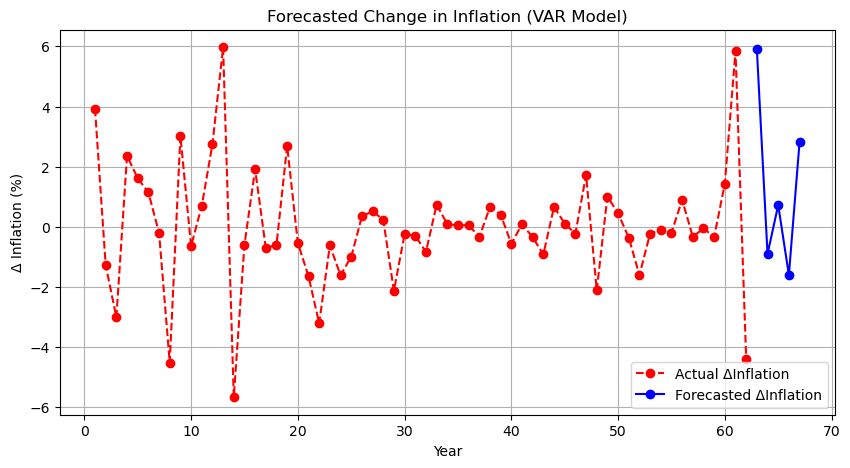

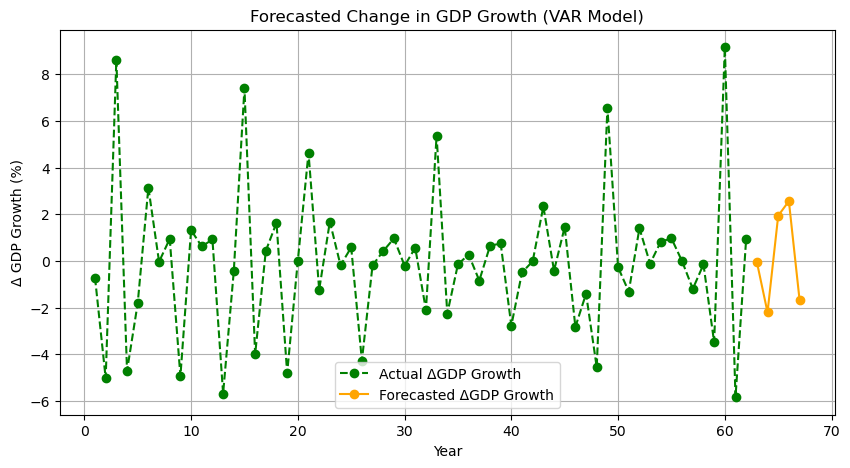

In [20]:
# Plot forecasted ΔInflation
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['ΔInflation'], label="Actual ΔInflation", linestyle='dashed', color='red', marker='o')
plt.plot(forecast_df['Year'], forecast_df['Predicted_ΔInflation'], label="Forecasted ΔInflation", linestyle='solid', color='blue', marker='o')
plt.xlabel("Year")
plt.ylabel("Δ Inflation (%)")
plt.title("Forecasted Change in Inflation (VAR Model)")
plt.legend()
plt.grid(True)
plt.show()

# Plot forecasted ΔGDP Growth
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['ΔGDP_Growth'], label="Actual ΔGDP Growth", linestyle='dashed', color='green', marker='o')
plt.plot(forecast_df['Year'], forecast_df['Predicted_ΔGDP_Growth'], label="Forecasted ΔGDP Growth", linestyle='solid', color='orange', marker='o')
plt.xlabel("Year")
plt.ylabel("Δ GDP Growth (%)")
plt.title("Forecasted Change in GDP Growth (VAR Model)")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
if 'Predicted_ΔInflation' in forecast_df.columns:
    # Step 1: Convert ΔΔInflation to ΔInflation (add the last ΔInflation value)
    forecast_df['Predicted_ΔInflation'] = df['ΔInflation'].iloc[-1] + forecast_df['Predicted_ΔInflation'].cumsum()

    # Step 2: Convert ΔInflation back to actual Inflation (add the last actual Inflation value)
    forecast_df['Predicted_Inflation'] = df['Inflation'].iloc[-1] + forecast_df['Predicted_ΔInflation'].cumsum()

from IPython.display import display
display(forecast_df)


,Predicted_ΔGDP_Growth,Predicted_ΔInflation,Year,Predicted_Inflation
0,-0.042827,1.520617,63,4.825795
1,-2.203219,0.615126,64,5.440921
2,1.939193,1.335748,65,6.776669
3,2.565265,-0.268242,66,6.508427
4,-1.667284,2.545883,67,9.054310


/Users/sergiobd373/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


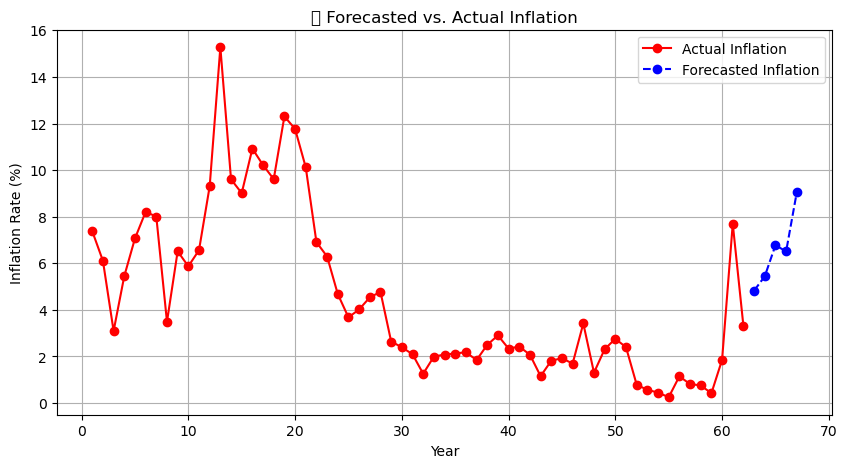

In [23]:
import matplotlib.pyplot as plt

# Plot the actual and forecasted inflation
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Inflation'], label="Actual Inflation", linestyle='solid', color='red', marker='o')
plt.plot(forecast_df['Year'], forecast_df['Predicted_Inflation'], label="Forecasted Inflation", linestyle='dashed', color='blue', marker='o')
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%)")
plt.title("📈 Forecasted vs. Actual Inflation")
plt.legend()
plt.grid(True)
plt.show()


/Users/sergiobd373/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


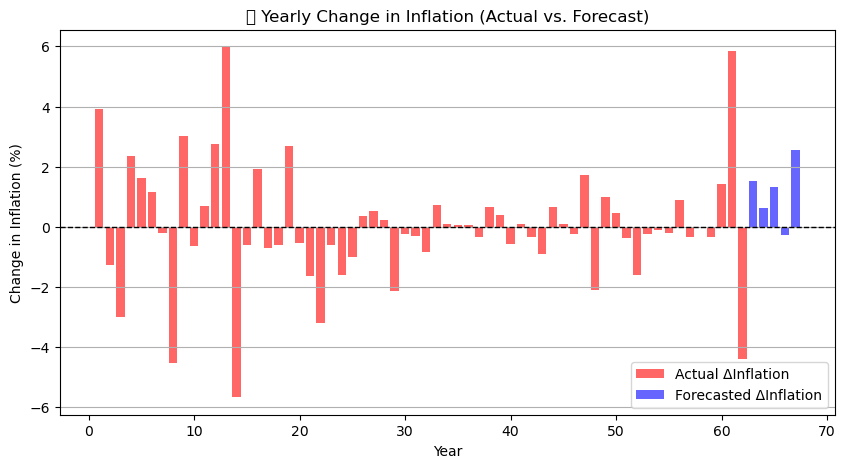

In [24]:
plt.figure(figsize=(10, 5))

plt.bar(df.index, df['ΔInflation'], color="red", label="Actual ΔInflation", alpha=0.6)

plt.bar(forecast_df['Year'], forecast_df['Predicted_ΔInflation'], color="blue", label="Forecasted ΔInflation", alpha=0.6)

plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Year")
plt.ylabel("Change in Inflation (%)")
plt.title("📊 Yearly Change in Inflation (Actual vs. Forecast)")
plt.legend()
plt.grid(axis='y')
plt.show()